In [1]:
# #@title notebook setup
if 'colab' in str(get_ipython()):
    !pip install pingouin
    from rpy2.robjects.packages import importr
    utils = importr('utils')
    utils.install_packages('lme4')
else:
    import os
    #set the appropriate path to whichever R installation we'd like to use
    os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/rpython/lib/R'
import rpy2
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
from fnc_analysis import *
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from pathlib import Path

/Users/nathanielnyema/opt/anaconda3/envs/rpython/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/nathanielnyema/opt/anaconda3/envs/rpython/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#@title figure settings
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype']='none'
fig_save_loc = Path('../figures')
ctl_col = '#D4D4D4'
stim_col = '#06e1e9'

In [4]:
#@title load tidy data and subset dataframes for later use

#load sated
df_s = load_data('../pre_processed/sated2/total_licks_sated2.csv')
dft_s = load_data('../pre_processed/sated2/lick_times_sated2.csv')

#load extinction
df_ex1 = load_data('../pre_processed/unused/extinction1/total_licks_extinction1.csv')
dft_ex1 = load_data('../pre_processed/unused/extinction1/lick_times_extinction1.csv')

#select glucose data
#sated
df_test_g_st = subset_df(df_s, 'glucose', 'test') 
dft_test_g_st = subset_df(dft_s, 'glucose', 'test') 

df_train_g_st = subset_df(df_s, 'glucose', 'training') 
dft_train_g_st = subset_df(dft_s, 'glucose', 'training') 

#extinction
df_test_g_ex1 = subset_df(df_ex1, 'glucose', 'test') 
dft_test_g_ex1 = subset_df(dft_ex1, 'glucose', 'test') 

df_train_g_ex1 = subset_df(df_ex1, 'glucose', 'training') 
dft_train_g_ex1 = subset_df(dft_ex1, 'glucose', 'training') 


#select fat data
#sated
df_test_f_st = subset_df(df_s, 'fat', 'test') 
dft_test_f_st = subset_df(dft_s, 'fat', 'test') 

df_train_f_st = subset_df(df_s, 'fat', 'training') 
dft_train_f_st = subset_df(dft_s, 'fat', 'training') 


### unlimited intake, sated
 unlimited intake, sated
In these experiments, mice were allowed ad-libitum access to food and water in their home cages throughout training and testing. During the training sessions they were allowed unrestricted access to the flavored solutions. 

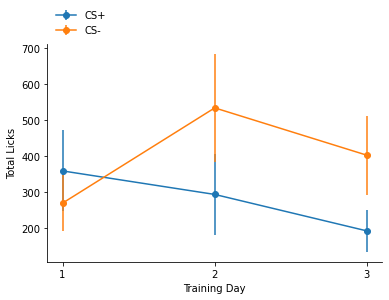

In [16]:
mn = df_train_g_st.groupby(['day','CS'])['total_licks'].mean()
sem = df_train_g_st.groupby(['day','CS'])['total_licks'].sem()

plt.errorbar(mn.loc[:,'+'].index, mn.loc[:,'+'] ,  yerr = sem.loc[:,'+'], marker = 'o', label = 'CS+')
plt.errorbar(mn.loc[:,'-'].index, mn.loc[:,'-'] ,  yerr = sem.loc[:,'-'], marker = 'o', label = 'CS-')
plt.xticks([0,1,2], [1,2,3])
plt.ylabel('Total Licks')
plt.xlabel('Training Day')
plt.legend(frameon=False, bbox_to_anchor = (0,1), loc = "lower left")
sns.despine()

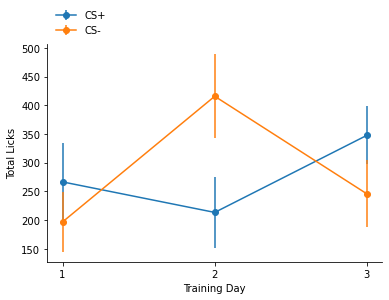

In [70]:
mn = df_train_f_st.groupby(['day','CS'])['total_licks'].mean()
sem = df_train_f_st.groupby(['day','CS'])['total_licks'].sem()
plt.errorbar(mn.loc[:,'+'].index, mn.loc[:,'+'] ,  yerr = sem.loc[:,'+'], marker = 'o', label = 'CS+')
plt.errorbar(mn.loc[:,'-'].index, mn.loc[:,'-'] ,  yerr = sem.loc[:,'-'], marker = 'o', label = 'CS-')
plt.xticks([0,1,2], [1,2,3])
plt.ylabel('Total Licks')
plt.xlabel('Training Day')
plt.legend(frameon=False, bbox_to_anchor = (0,1), loc = "lower left")
sns.despine()

In [4]:
df = load_data('../pre_processed/unlimited_intake/total_licks_normal_intake.csv')
dft = load_data('../pre_processed/unlimited_intake/lick_times_normal_intake.csv')

df_test_g = subset_df(df, 'glucose', 'test')
dft_test_g = subset_df(dft, 'glucose', 'test')

df_train_g = subset_df(df, 'glucose', 'training')
dft_train_g = subset_df(dft, 'glucose', 'training')

df_test_f = subset_df(df, 'fat', 'test') 
dft_test_f = subset_df(dft, 'fat', 'test') 

df_train_f = subset_df(df, 'fat', 'training') 
dft_train_f = subset_df(dft, 'fat', 'training') 

/Users/nathanielnyema/opt/anaconda3/envs/rpython/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
#@title constructing the dataframe
#let's factor in the feeding data
df=pd.read_csv('../raw_data/normal_intake/opto_stim_feeding.csv')
df = df.dropna().set_index(["Chr2","Mouse"]).sort_index()
df = df.stack().astype(float)
df.name = "intake"
df = pd.concat({'Glucose': df.loc[:,:,'glucose'],
                'Water': df.loc[:,:,'water'],
                'Fat': df.loc[:,:,'fat']}, 
               names = ['infusion'])
df = df.reset_index()
df = df.rename(columns = {"Mouse": "mouse"})

tlg = df_test_g.total_licks
tlg = tlg.groupby(['Chr2','mouse','CS']).sum().unstack('CS')
prefs_g = tlg['+']/(tlg['+'] + tlg['-'])
prefs_g = pd.concat({'pref': prefs_g, 'total': tlg.sum(axis=1)}, axis=1)
tlf = df_test_f.total_licks
tlf = tlf.groupby(['Chr2','mouse','CS']).sum().unstack('CS')
prefs_f = tlf['+']/(tlf['+'] + tlf['-'])
prefs_f = pd.concat({'pref': prefs_f, 'total': tlf.sum(axis=1)}, axis=1)

df2 = df.set_index(['infusion','Chr2','mouse']).sort_index().intake
#put together the glucose dataframe
g = (df2.loc['Glucose'] - df2.loc['Water'])/df2.loc['Water']
g = pd.concat(( g,prefs_g), axis=1).reset_index('Chr2')
g['csp_train'] = (df_train_g.loc[:,g.index,:, '+']
                             .groupby(['mouse'])
                             .total_licks.mean())
g['csm_train'] = (df_train_g.loc[:,g.index,:, '-']
                             .groupby(['mouse'])
                             .total_licks.mean())

late_sess_licks = dft_train_g.loc[dft_train_g.time>=15*60].groupby(['Chr2','mouse','day','CS']).size()
early_sess_licks = dft_train_g.loc[dft_train_g.time<15*60].groupby(['Chr2','mouse','day','CS']).size()
diff_to_inf_start = dft_train_g.time - dft_train_g.loc[dft_train_g.lick_number ==20].time
during = diff_to_inf_start.loc[diff_to_inf_start.between(0, 10*60)].groupby(['Chr2','mouse','day','CS']).size()
g['csp_train_late'] = late_sess_licks.loc[:,:,:,'+'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
g['csm_train_late']  = late_sess_licks.loc[:,:,:,'-'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
g['csp_train_early'] = early_sess_licks.loc[:,:,:,'+'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
g['csm_train_early']  = early_sess_licks.loc[:,:,:,'-'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
g['csp_train_during']  = during.loc[:,:,:,'+'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
g['csm_train_during']  = during.loc[:,:,:,'-'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
sexes = (df_test_g.droplevel(['Chr2','CS','day'])
                  .reset_index()
                  .drop_duplicates('mouse')
                  .set_index('mouse').sex)
g['sex'] = sexes.loc[g.index]
# g = g.rename(columns = {'total_licks':'pref'})

#do the same for fat
f = (df2.loc['Fat']- df2.loc['Water'])/df2.loc['Water']
f = pd.concat(( f, prefs_f), axis=1).reset_index('Chr2')
f['csp_train'] = (df_train_f.loc[:,f.index,:, '+']
                             .groupby(['mouse'])
                             .total_licks.mean())
f['csm_train'] = (df_train_f.loc[:,f.index,:, '-']
                             .groupby(['mouse'])
                             .total_licks.mean())
# f= f.rename(columns = {'total_licks':'pref'})
late_sess_licks = dft_train_f.loc[dft_train_f.time>=15*60].groupby(['Chr2','mouse','day','CS']).size()
early_sess_licks = dft_train_f.loc[dft_train_f.time<15*60].groupby(['Chr2','mouse','day','CS']).size()
diff_to_inf_start = dft_train_f.time - dft_train_f.loc[dft_train_f.lick_number ==20].time
during = diff_to_inf_start.loc[diff_to_inf_start.between(0, 10*60)].groupby(['Chr2','mouse','day','CS']).size()
f['csp_train_late'] = late_sess_licks.loc[:,:,:,'+'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
f['csm_train_late']  = late_sess_licks.loc[:,:,:,'-'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
f['csp_train_early'] = early_sess_licks.loc[:,:,:,'+'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
f['csm_train_early']  = early_sess_licks.loc[:,:,:,'-'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
f['csp_train_during']  = during.loc[:,:,:,'+'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
f['csm_train_during']  = during.loc[:,:,:,'-'].groupby(['Chr2', 'mouse']).mean().droplevel("Chr2")
sexes = (df_test_f.droplevel(['Chr2','CS','day'])
                  .reset_index()
                  .drop_duplicates('mouse')
                  .set_index('mouse').sex)
f['sex'] = sexes.loc[f.index]
#concatenate
df3 = pd.concat({'glucose': g, 'fat':f}, names = ['US']).reset_index()
df3.head(10)

,US,mouse,Chr2,intake,pref,total,csp_train,csm_train,csp_train_late,csm_train_late,csp_train_early,csm_train_early,csp_train_during,csm_train_during,sex
0,glucose,adm228,False,-0.625229,0.863229,892.0,645.333333,166.000000,260.000000,73.666667,385.333333,92.333333,297.666667,66.666667,M
1,glucose,adm229,False,-0.807339,0.715782,2769.0,1060.333333,764.000000,388.666667,356.000000,671.666667,408.000000,490.000000,265.666667,M
2,glucose,adm230,False,-0.625532,0.603458,1793.0,1003.666667,706.333333,409.000000,238.000000,594.666667,468.333333,453.666667,405.333333,M
3,glucose,adm231a,False,NaN,0.469746,2165.0,350.666667,435.333333,121.000000,215.333333,229.666667,220.000000,194.000000,172.666667,M
4,glucose,adm231b,False,-0.287926,0.995409,4356.0,1531.333333,878.000000,361.666667,229.000000,1169.666667,649.000000,1011.333333,540.000000,M
5,glucose,adm232,False,NaN,0.741408,2386.0,1207.000000,584.333333,323.333333,179.666667,883.666667,404.666667,746.333333,382.666667,F
6,glucose,adm233,False,-0.696035,0.984021,3442.0,888.666667,380.333333,217.333333,173.666667,671.333333,206.666667,631.000000,178.666667,F
7,glucose,adm234,False,NaN,0.689601,2558.0,730.666667,588.666667,209.500000,159.000000,591.000000,429.666667,544.333333,348.333333,F
8,glucose,adm235,False,NaN,0.909792,2982.0,1038.333333,590.000000,435.500000,198.000000,748.000000,392.000000,600.333333,316.666667,F
9,glucose,adm236,False,NaN,0.924392,3042.0,381.333333,427.000000,66.000000,136.000000,315.333333,291.000000,295.333333,224.000000,F


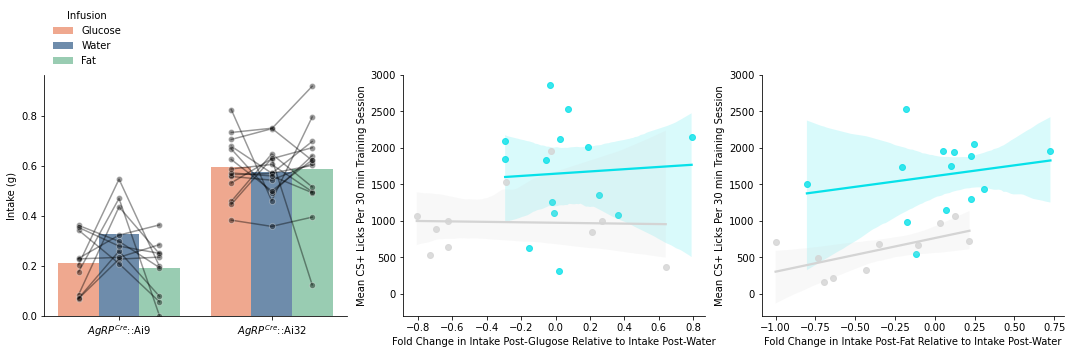

In [12]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
df['x'] = df.Chr2.astype(int)
disp = .265
df['x'] = df.x + df.infusion.replace({'Glucose': -disp, 'Water': 0, 'Fat': disp})
sns.barplot(data=df, x='Chr2', y='intake', order = [False, True], ax=ax[0], 
                hue = 'infusion', hue_order = ['Glucose', 'Water', 'Fat'],
                palette = ['#ffa07f', '#648cb5','#91d4b2'], ci=None)
sns.lineplot(data=df, x='x', y='intake', hue='mouse', ax=ax[0],
             legend=False, marker = 'o', palette = ['k']*df.mouse.unique().size, alpha=.4)
ax[0].set_xlabel('')
ax[0].set_xticklabels([r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'])
ax[0].set_ylabel('Intake (g)')
ax[0].legend(loc='lower left', bbox_to_anchor = (0,1), frameon = False, title = 'Infusion', )

sns.regplot(data = g.loc[g.Chr2==True], x='intake', y='csp_train', ax=ax[1], color = "#06e1e9")
sns.regplot(data = g.loc[g.Chr2==False], x='intake', y='csp_train', ax=ax[1], color = '#D4D4D4')
ax[1].set_xlabel('Fold Change in Intake Post-Glugose Relative to Intake Post-Water')
ax[1].set_ylabel('Mean CS+ Licks Per 30 min Training Session')
ax[1].set_ylim(-300, 3000)

sns.regplot(data = f.loc[f.Chr2==True], x='intake', y='csp_train', ax=ax[2], color = "#06e1e9")
sns.regplot(data = f.loc[f.Chr2==False], x='intake', y='csp_train', ax=ax[2], color = '#D4D4D4')
ax[2].set_xlabel('Fold Change in Intake Post-Fat Relative to Intake Post-Water')
ax[2].set_ylabel('Mean CS+ Licks Per 30 min Training Session')
ax[2].set_ylim(-300, 3000)


sns.despine()

fig.tight_layout(pad=1.0)

fig.savefig(fig_save_loc/'pdfs'/'optofeeding.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'optofeeding.svg', transparent=True, bbox_inches='tight')



all of the ctl mice that ate more after fat compared to water had a strong preference induced by fat. most that that ate less after fat compared to after water did not have a preference or just a weak one. hmm i wonder if the mice that ate less after fat also stopped licking after their infusions during training...cause we also know that the teaching signal for fat is supposedly slower than for glucose. if those mice are no longer licking at the time when the reinforcement signal is strongest perhaps they wont develop a preference. but this begs the question, amongs the controls, why do some mice stop eating after fat infusions while others don't? it's as if some of these mice are primarily motivated to eat based on the energy deficit so once they're full, they're fine?

#### stats for the satiation study

In [6]:
#check for normality
df.groupby(["Chr2","infusion"])["intake"].apply(lambda x: st.shapiro(x)[1])

Chr2   infusion
False  Fat         0.588244
       Glucose     0.158001
       Water       0.119130
True   Fat         0.331058
       Glucose     0.996442
       Water       0.859342
Name: intake, dtype: float64

In [7]:
import pingouin as pg
pg.mixed_anova( data = df, dv = 'intake', within = 'infusion', subject = 'mouse', between = 'Chr2')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Chr2,2.052289,1,22,2.052289,81.621934,7.405253e-09,0.787690,NaN
1,infusion,0.033603,2,44,0.016801,1.245659,2.976996e-01,0.053587,0.871338
2,Interaction,0.078578,2,44,0.039289,2.912933,6.485629e-02,0.116925,NaN


In [8]:
pg.pairwise_ttests( data = df, dv = 'intake', within = 'infusion', subject = 'mouse', between = 'Chr2')

,Contrast,infusion,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,infusion,-,Fat,Glucose,True,True,-0.502911,23.000000,two-sided,6.198087e-01,0.241,-0.058908
1,infusion,-,Fat,Water,True,True,-1.271540,23.000000,two-sided,2.162449e-01,0.439,-0.235622
2,infusion,-,Glucose,Water,True,True,-1.062061,23.000000,two-sided,2.992332e-01,0.356,-0.183771
3,Chr2,-,False,True,False,True,-9.911432,20.956698,two-sided,2.310630e-09,4.414e+06,-3.611645
4,infusion * Chr2,Fat,False,True,False,True,-6.447772,21.562970,two-sided,1.911203e-06,6817.669,-2.377802
5,infusion * Chr2,Glucose,False,True,False,True,-7.882617,20.176719,two-sided,1.377011e-07,1.148e+05,-3.121722
6,infusion * Chr2,Water,False,True,False,True,-5.338906,18.477928,two-sided,4.111804e-05,699.101,-2.165898


#### considering different phases of the training sessions

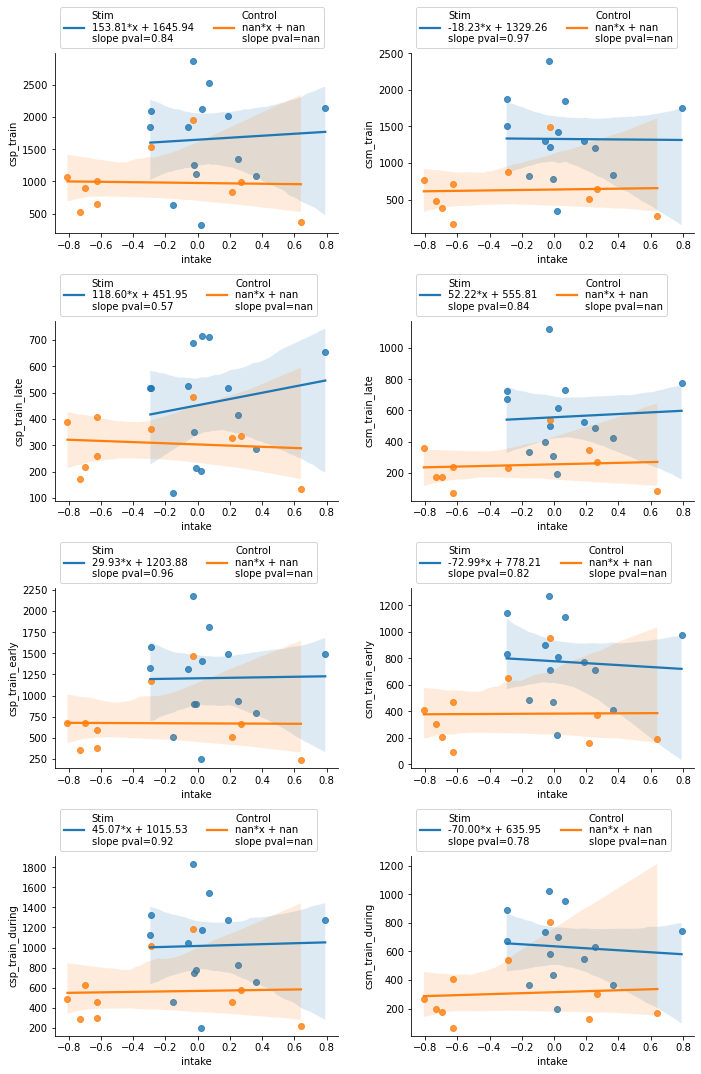

In [9]:
#BE CAREFUL HERE: WE CANNOT COMPARE GLUCOSE AND FAT
fig, ax = plt.subplots(4,2, figsize=(10,15))
x = ['intake']*8
y = ['csp_train', 'csm_train', 
     'csp_train_late', 'csm_train_late',
     'csp_train_early', 'csm_train_early',
     'csp_train_during', 'csm_train_during']
for i,(xx,yy) in enumerate(zip(x,y)):
    res = st.linregress(g.loc[g.Chr2==True,xx], g.loc[g.Chr2==True,yy])
    sns.regplot(data = g.loc[g.Chr2==True], x=xx, y=yy, ax=ax.flatten()[i], 
            line_kws={'label': f"Stim\n{res.slope:.2f}*x + {res.intercept:.2f}\nslope pval={res.pvalue:.2f}"})
    res = st.linregress(g.loc[g.Chr2==False,xx], g.loc[g.Chr2==False,yy])
    gg = sns.regplot(data = g.loc[g.Chr2==False], x=xx, y=yy, ax=ax.flatten()[i],
            line_kws={'label': f"Control\n{res.slope:.2f}*x + {res.intercept:.2f}\nslope pval={res.pvalue:.2f}"})
    gg.legend(loc="lower left", ncol=2, bbox_to_anchor=(0,1))
    sns.despine()
sns.despine()
fig.tight_layout(pad=1.)

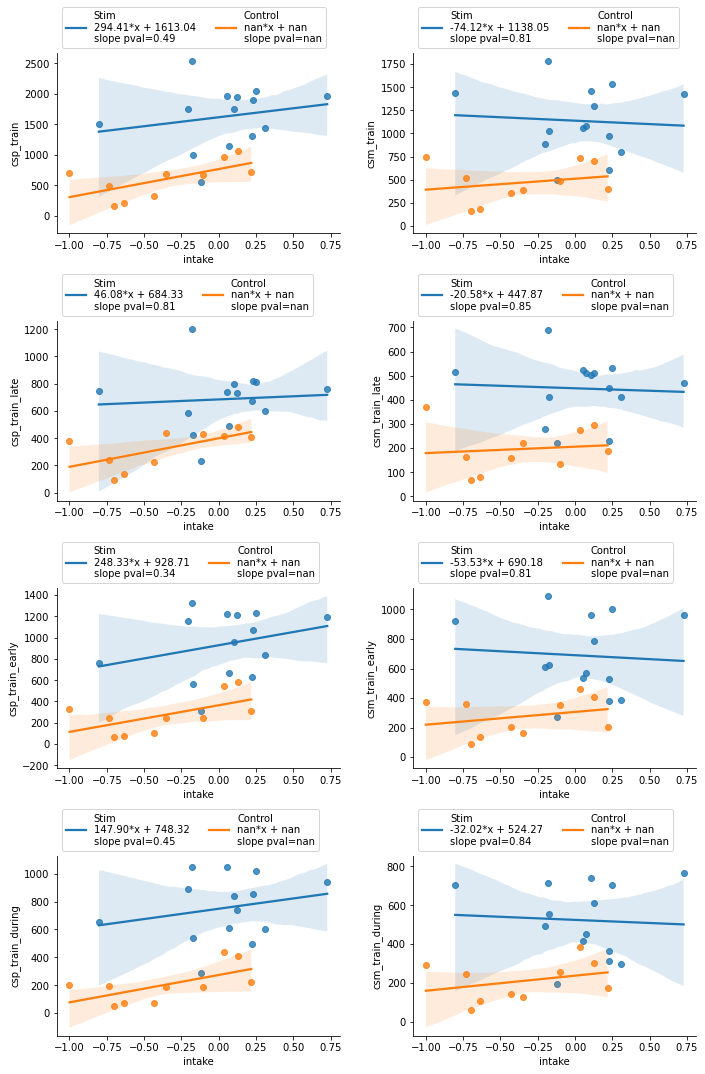

In [10]:
#BE CAREFUL HERE: WE CANNOT COMPARE GLUCOSE AND FAT
fig, ax = plt.subplots(4,2, figsize=(10,15))
x = ['intake']*8
y = ['csp_train', 'csm_train', 
     'csp_train_late', 'csm_train_late',
     'csp_train_early', 'csm_train_early',
     'csp_train_during', 'csm_train_during']
for i,(xx,yy) in enumerate(zip(x,y)):
    res = st.linregress(f.loc[f.Chr2==True,xx], f.loc[f.Chr2==True,yy])
    sns.regplot(data = f.loc[f.Chr2==True], x=xx, y=yy, ax=ax.flatten()[i], 
            line_kws={'label': f"Stim\n{res.slope:.2f}*x + {res.intercept:.2f}\nslope pval={res.pvalue:.2f}"})
    res = st.linregress(f.loc[f.Chr2==False,xx], f.loc[f.Chr2==False,yy])
    gg = sns.regplot(data = f.loc[f.Chr2==False], x=xx, y=yy, ax=ax.flatten()[i],
            line_kws={'label': f"Control\n{res.slope:.2f}*x + {res.intercept:.2f}\nslope pval={res.pvalue:.2f}"})
    gg.legend(loc="lower left", ncol=2, bbox_to_anchor=(0,1))
    sns.despine()
sns.despine()
fig.tight_layout(pad=1.)

intake mostly only correlates with training licks for csp fat licks

### preference vs intake

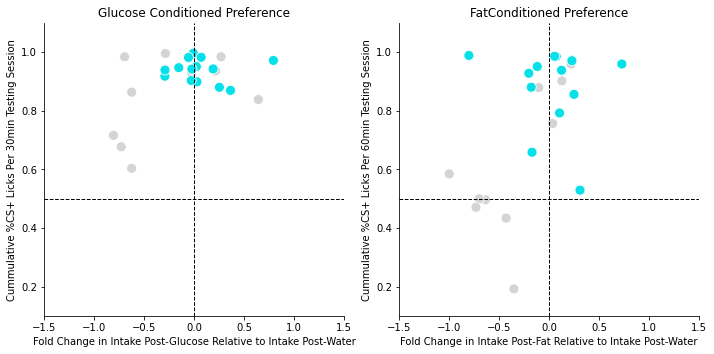

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].axhline(0.5, color = 'k', ls='--', lw=1)
ax[0].axvline(0, color = 'k', ls='--', lw=1)
sns.scatterplot(data = g, hue='Chr2', x='intake', s=100, palette = [ctl_col, stim_col], y='pref', ax=ax[0], legend=False)
ax[0].set_xlabel('Fold Change in Intake Post-Glucose Relative to Intake Post-Water')
ax[0].set_ylabel('Cummulative %CS+ Licks Per 30min Testing Session')
ax[0].set_title('Glucose Conditioned Preference')
ax[0].set_ylim(0.1,1.1)
ax[0].set_xlim(-1.5,1.5)
ax[1].axhline(0.5, color = 'k', ls='--', lw=1)
ax[1].axvline(0, color = 'k', ls='--', lw=1)
sns.scatterplot(data = f, hue='Chr2', x='intake', s=100, palette = [ctl_col, stim_col], y='pref', ax=ax[1], legend=False)
ax[1].set_xlabel('Fold Change in Intake Post-Fat Relative to Intake Post-Water')
ax[1].set_ylabel('Cummulative %CS+ Licks Per 60min Testing Session')
ax[1].set_title('FatConditioned Preference')
ax[1].set_ylim(0.1,1.1)
ax[1].set_xlim(-1.5,1.5)
fig.tight_layout(pad=1.0)
sns.despine()
fig.savefig('optofeeding1.pdf')
fig.savefig('optofeeding1.svg')


In [59]:
t = np.arange(0,1800)
cl = dft_test_g.set_index('sex', append=True).time.groupby(['Chr2','mouse','day', 'CS', 'sex']).apply(lambda x: pd.Series((x.values[:,None]<t[None,:]).sum(axis=0), index=pd.Index(t, name='t'))).rename('licks')

<AxesSubplot: xlabel='t', ylabel='licks'>

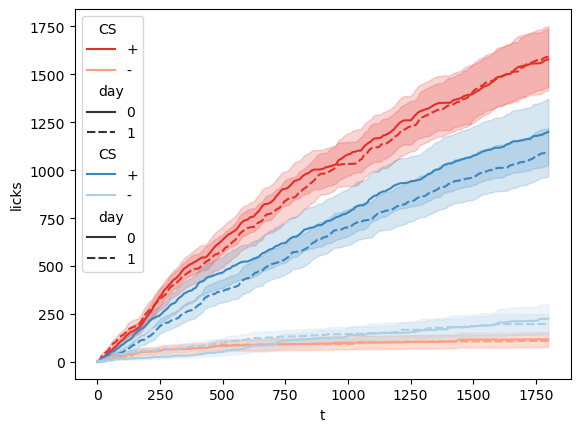

In [64]:

sns.lineplot(cl.loc[True,].reset_index(), x= 't', y='licks', hue='CS', style='day', errorbar='se', palette = 'Reds_r')
sns.lineplot(cl.loc[False,].reset_index(), x= 't', y='licks', hue='CS', style='day', errorbar='se', palette = 'Blues_r')

<AxesSubplot: xlabel='t', ylabel='pref'>

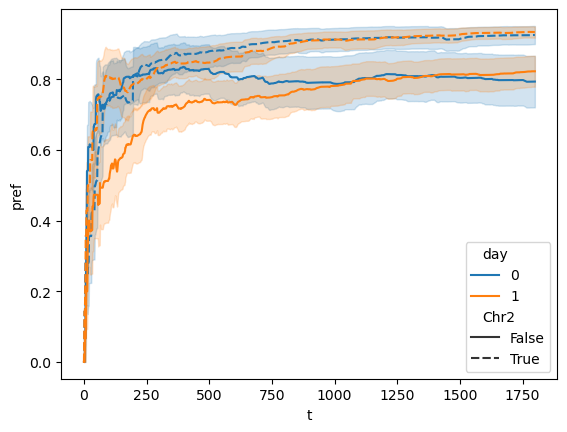

In [70]:
p = cl.unstack('CS').apply(lambda x: x['+']/(x['+']+x['-']) if (x['+'] + x['-']) >0 else 0, axis=1).rename('pref')
sns.lineplot(p.reset_index(), x='t', y='pref', style='Chr2', hue='day',errorbar='se') 